## 소개
* Dataset와 DataLoader의 추상화를 응용하고 어떻게 훈련 루프 중에 모델에 데이터를 공급하는 지 알아보자
* 구체적인 손실 함수와 이를 언제 사용하는지 알아보자
* 손실 함수의 결과를 기반으로 모델 가중치를 조정하는 알고리즘을 구현하는 최적화 프로그램을 구성해보자

## Dataset 및 DataLoader
##### Dataset은 데이터 인스턴스의 단일 액세스 및 처리를 담당한다.
##### DataLoader는 Dataset에서 데이터 인스턴스를 가져온다. 일괄 처리하고 훈련 루프에서 사용할 수 있도록 반환한다. 유형에 상관없이 모든 종류의 데이터 세트에서 작동한다.

##### Fashion-MNIST 데이터 세트를 사용하고, 데이터에 대해 ToTensor() 및 정규화 진행한다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 26421880/26421880 [00:03<00:00, 7986855.44it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 135749.38it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2540024.88it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15935259.77it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set has 60000 instances
Validation set has 10000 instances


##### 온전성 검사를 위해 데이터를 시각화해보자

Sneaker  Sneaker  Bag  Pullover


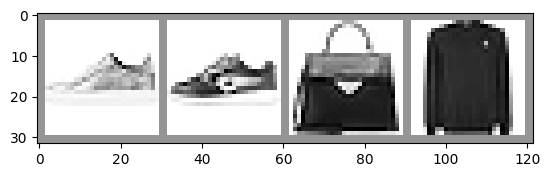

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

## 모델
##### 사용할 모델은 LeNet-5의 변형이다.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

## 손실함수
##### 교차 엔트로피 손실을 사용할 것이다. 먼저 더미 출력 및 레이브 값의 배치를 생성하고 실행한다.

In [4]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.5853, 0.2756, 0.0461, 0.0224, 0.9108, 0.1942, 0.8264, 0.7986, 0.0250,
         0.9960],
        [0.2867, 0.8535, 0.3630, 0.9531, 0.4483, 0.7079, 0.4668, 0.1637, 0.5710,
         0.1529],
        [0.6407, 0.1801, 0.2313, 0.4222, 0.0220, 0.2341, 0.3882, 0.4682, 0.8754,
         0.9524],
        [0.4074, 0.9274, 0.7896, 0.3393, 0.2626, 0.4796, 0.9721, 0.1167, 0.7789,
         0.7796]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.4665958881378174


## 옵티마이저
##### SGD 사용

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 훈련 루프
##### 각 루프에서 수행하는 과정에 대해서 설명할 것이다.
* DataLoader에서 훈련 데이터 배치를 가져온다.
* 옵티마이저 기울기를 0으로 만든다.
* 추론을 수행한다. 즉, 입력 배치에 대한 모델에서 예측을 가져온다.
* 해당 예측 세트와 데이터세트의 라벨에 대한 손실 계산한다.
* 학습 가중치에 대한 역방향 기울기를 계산한다.
* 옵티마이저에게 하나의 학습 단계를 수행하도록 지시한다. 즉, 모델의 해당 배치에 대해 관찰된 기울기를 기반으로 가중치를 학습한다.
* 1000개 배치마다 손실을 보고한다.
* 마지막으로 마지막 배치에 대한 평균 배치당 손실을 보고한다.

In [7]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

## 에포크별 활동
* 모델 검증 수행
* 모델 사본 저장

In [8]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.7239043242037295
  batch 2000 loss: 0.8446311861667782
  batch 3000 loss: 0.6995700877010822
  batch 4000 loss: 0.6724184019106906
  batch 5000 loss: 0.6196561690396629
  batch 6000 loss: 0.5579756995555945
  batch 7000 loss: 0.5507051926176064
  batch 8000 loss: 0.5107526173433289
  batch 9000 loss: 0.5018748321823078
  batch 10000 loss: 0.463261330672889
  batch 11000 loss: 0.48594683459517546
  batch 12000 loss: 0.44980855738610265
  batch 13000 loss: 0.45014170718489915
  batch 14000 loss: 0.4456974046757969
  batch 15000 loss: 0.4259508963028202
LOSS train 0.4259508963028202 valid 0.4468265771865845
EPOCH 2:
  batch 1000 loss: 0.4049182591715362
  batch 2000 loss: 0.41389355741627515
  batch 3000 loss: 0.4051698113981402
  batch 4000 loss: 0.36323978825163794
  batch 5000 loss: 0.3878389453412383
  batch 6000 loss: 0.37242968774202745
  batch 7000 loss: 0.36378389022417834
  batch 8000 loss: 0.360943821261928
  batch 9000 loss: 0.3525660427293333
  ba

##### 저장된 버전의 모델을 로드할려면 아래와 같이 수행한다.

In [ ]:
# saved_model = GarmentClassifier()
# saved_model.load_state_dict(torch.load(PATH))